In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tensorflow
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# The required pip installs, just run the cell. (Recommended to run in a venv environment)

In [1]:
import sys
import torch

print("System Information:")
print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

try:
    print("\nCUDA Details:")
    print("CUDA version:", torch.version.cuda)
    print("Number of CUDA devices:", torch.cuda.device_count())
    
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"\nDevice {i} Details:")
            print("Device name:", torch.cuda.get_device_name(i))
            print("Device properties:", torch.cuda.get_device_properties(i))
except Exception as e:
    print("Error retrieving CUDA information:", str(e))

print("\nEnvironment Checks:")
import os
print("CUDA_HOME:", os.environ.get('CUDA_HOME', 'Not set'))
print("PATH environment variable contains CUDA paths:", 
      any('cuda' in path.lower() for path in os.environ.get('PATH', '').split(os.pathsep)))

# This codeblock is to check if you have CUDA installed and configured correctly.
# It will print out the CUDA version, number of devices, and their properties.
# It also checks if the PATH environment variable contains CUDA paths.
# If you have any issues, please ensure that your CUDA installation is correct and that the paths are set properly.

System Information:
Python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PyTorch version: 2.7.0+cu118
CUDA available: True

CUDA Details:
CUDA version: 11.8
Number of CUDA devices: 1

Device 0 Details:
Device name: NVIDIA GeForce RTX 4080 SUPER
Device properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 4080 SUPER', major=8, minor=9, total_memory=16375MB, multi_processor_count=80, uuid=634fd6ef-c3a1-1f92-40af-f6db42b38a71, L2_cache_size=64MB)

Environment Checks:
CUDA_HOME: Not set
PATH environment variable contains CUDA paths: True


✅ Using device: cuda
⚠️ Found NaNs in data, filling...


C:\Users\HaL_27\AppData\Local\Temp\ipykernel_16260\1237277654.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


Epoch 1/50, Loss: 0.079682
🔄 Learning rate after epoch 1: 0.000500
✅ Saved new best model.
Epoch 2/50, Loss: 0.013029
🔄 Learning rate after epoch 2: 0.000500
✅ Saved new best model.
Epoch 3/50, Loss: 0.007424
🔄 Learning rate after epoch 3: 0.000500
✅ Saved new best model.
Epoch 4/50, Loss: 0.006757
🔄 Learning rate after epoch 4: 0.000500
✅ Saved new best model.
Epoch 5/50, Loss: 0.006368
🔄 Learning rate after epoch 5: 0.000500
✅ Saved new best model.
Epoch 6/50, Loss: 0.005716
🔄 Learning rate after epoch 6: 0.000500
✅ Saved new best model.
Epoch 7/50, Loss: 0.005465
🔄 Learning rate after epoch 7: 0.000500
✅ Saved new best model.
Epoch 8/50, Loss: 0.005232
🔄 Learning rate after epoch 8: 0.000500
✅ Saved new best model.
Epoch 9/50, Loss: 0.004820
🔄 Learning rate after epoch 9: 0.000500
✅ Saved new best model.
Epoch 10/50, Loss: 0.004532
🔄 Learning rate after epoch 10: 0.000500
✅ Saved new best model.
Epoch 11/50, Loss: 0.004164
🔄 Learning rate after epoch 11: 0.000500
✅ Saved new best mo

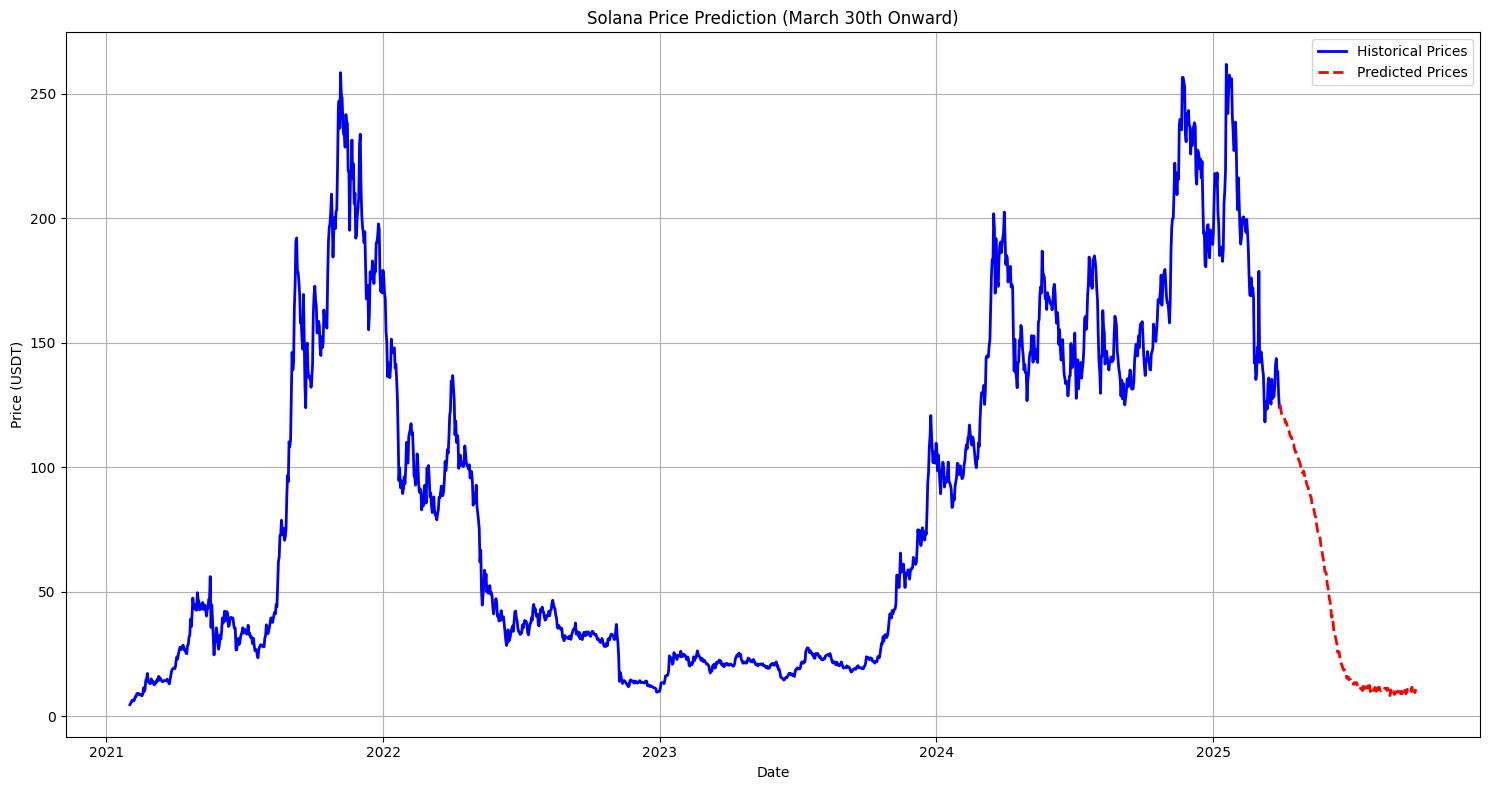

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import random

# Set seeds for consistent results
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ---------- Device Selection ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ---------- Data Preparation ----------
def prepare_data(csv_path, sequence_length=180):
    solana_data = pd.read_csv(csv_path)
    solana_data['Date'] = pd.to_datetime(solana_data['Date'], format='%m/%d/%Y')
    solana_data.set_index('Date', inplace=True)
    solana_data = solana_data.iloc[::-1]

    solana_data['Change%'] = solana_data['Change%'].str.replace('%', '', regex=False).astype(float)
    solana_data['Volume'] = solana_data['Volume'].astype(str).str.replace(',', '').astype(float)

    solana_data['Momentum_7d'] = solana_data['Price'].pct_change(7).fillna(0)
    solana_data['Momentum_14d'] = solana_data['Price'].pct_change(14).fillna(0)

    features = ['Price', 'Open', 'High', 'Low', 'Volume', 'Change%', 'Momentum_7d', 'Momentum_14d']
    data = solana_data[features]

    if data.isnull().any().any():
        print("⚠️ Found NaNs in data, filling...")
        data = data.fillna(method='ffill').fillna(method='bfill')

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i])

    X_tensor = torch.tensor(np.array(X), dtype=torch.float32)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    return loader, scaler, scaled_data, solana_data, features

# ---------- Model Definition ----------
class LSTMModel(nn.Module):
    def __init__(self, num_features):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=num_features, hidden_size=150, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=150, hidden_size=150, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(150, 100)
        self.fc2 = nn.Linear(100, num_features)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# ---------- Training Function ----------
def train_model(model, loader, epochs=50, lr=0.0005, patience=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_loss = float('inf')
    patience_counter = 0

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

        scheduler.step(avg_loss)
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print(f"🔄 Learning rate after epoch {epoch+1}: {current_lr:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("✅ Saved new best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    model.load_state_dict(torch.load('best_model.pth'))


# ---------- Forecasting Function ----------
def forecast_future(model, scaler, scaled_data, num_features, sequence_length=180, days_to_forecast=180, noise_seed=42):
    np.random.seed(noise_seed)  # Ensure forecast noise is stable between runs
    model.eval()
    last_sequence = scaled_data[-sequence_length:].astype(np.float32)
    predictions = []

    for i in range(days_to_forecast):
        input_seq = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            next_features = model(input_seq).cpu().numpy()[0]

        noise = np.random.normal(0, 0.003, size=num_features)
        next_features_noisy = np.clip(next_features + noise, 0, 1)
        predictions.append(next_features_noisy)

        if i == 0:
            first_predicted_price = scaler.inverse_transform(next_features_noisy.reshape(1, -1))[0][0]
            print(f"Predicted price for March 30, 2025: ${first_predicted_price:.4f}")

        last_sequence = np.vstack((last_sequence[1:], next_features_noisy))

    predicted_full = np.array(predictions)
    predicted_prices = scaler.inverse_transform(predicted_full)[:, 0]
    return predicted_prices


# ---------- Plotting Function ----------
def plot_predictions(solana_data, predicted_prices, start_date="2025-03-30", output_csv='files/solana_predictions.csv'):
    future_dates = pd.date_range(start=start_date, periods=len(predicted_prices), freq='D')
    predicted_df = pd.DataFrame({'Predicted Price': predicted_prices}, index=future_dates)
    predicted_df.to_csv(output_csv, index_label='Date')

    plt.figure(figsize=(15, 8))
    plt.plot(solana_data.index, solana_data['Price'], label='Historical Prices', color='blue', linewidth=2)
    plt.plot(predicted_df.index, predicted_df['Predicted Price'], label='Predicted Prices', linestyle='--', color='red', linewidth=2)
    plt.title('Solana Price Prediction (March 30th Onward)')
    plt.xlabel('Date')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------- Pipeline ----------
if __name__ == "__main__":
    loader, scaler, scaled_data, solana_data, features = prepare_data('files/solana.csv')
    num_features = len(features)

    model = LSTMModel(num_features=num_features).to(device)
    train_model(model, loader, epochs=50, patience=5)

    predicted_prices = forecast_future(model, scaler, scaled_data, num_features)
    plot_predictions(solana_data, predicted_prices)
